## First models

### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import time
import numpy as np

import ast
from collections import Counter

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection, metrics
from nrclex import NRCLex

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bapti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bapti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bapti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df_train = pd.read_csv("data/train.txt", names=["text", "emotion"], sep=";")
df_test = pd.read_csv("data/test.txt", names=["text", "emotion"], sep=";")
df_train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


### Data prep

In [3]:
# load stopwords
sw_file = open('misc/stopwords.txt', "r")
try :
    content = sw_file.read()
    stopwords = ast.literal_eval(content)
finally:
    sw_file.close()
    
# separate text and labels
X, y = list(df_train['text']), list(df_train['emotion'])

# Turn labels to numeric
emotion_list = list(df_train['emotion'].unique())
y_names = list(df_train['emotion'])
y = [emotion_list.index(em) for em in y]



In [4]:

def preprocess(text_lst, sw=False, stem=False, lem=True):
    """
    Apply different preprocessing.
    returns :
        - list of texts preprocessed
    params : 
        - list(str) text_lst : list of text to preprocess
        - bool sw : enable to remove stopwords
        - bool stem : enable to stem text
        - bool lem : enable to lemmatize text
    """
    time_start = time.time()
    if sw :
        text_lst = [' '.join([word for word in x.split() if word not in (stopwords)]) for x in text_lst]
    
    stemmer = SnowballStemmer('english')
    lem = WordNetLemmatizer()
    
    if stem and lem :
        text_lst = [' '.join([stemmer.stem(lem.lemmatize(word)) for word in x.split()]) for x in text_lst]
    
    elif stem :
        text_lst = [' '.join([stemmer.stem(word) for word in x.split()]) for x in text_lst]
        
    elif lem :
        text_lst = [' '.join([lem.lemmatize(word) for word in x.split()]) for x in text_lst]
    
    print(f'Time elapsed : {round(time.time() - time_start, 2)} s')
    
    return text_lst

#X_preproc = preprocess(X, sw=False, stem=True, lem=True)

### Models

### #1 Simple classification with tf/idf

#### Text encoding : tf/idf with refined vocabulary

In [133]:
# preprocessing
X_preproc = preprocess(X, sw=True, stem=True, lem=True)

Time elapsed : 2.61 s


In [134]:
# tfidf vectorizer
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(X_preproc)
X_train = vectorizer.transform(X_preproc)
vocabulary = vectorizer.vocabulary_ # getting vcabulary

In [135]:
# Chi square test to test features independancy : dimensionality reduction
# print below features linked to each subject

X_names = vectorizer.get_feature_names()
p_val = .95

features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    features = features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    features = features.sort_values(["y","score"], 
                    ascending=[True,False])
    features = features[features["score"]>p_val]

X_names = features["feature"].unique().tolist()

for cat in np.unique(y):
    print(f'# {emotion_list[cat]}')
    print(f'Top features selected : {len(dtf_features[dtf_features["y"]==cat])}')
    print(dtf_features[dtf_features["y"]==cat]["feature"].values[:10])
    print()

# sadness
Top features selected : 590
['punish' 'miser' 'gloomi' 'discourag' 'dishearten' 'exhaust' 'melancholi'
 'sorri' 'listless' 'letharg']

# anger
Top features selected : 303
['angri' 'annoy' 'bitchi' 'bitter' 'bother' 'cold' 'cranki' 'danger'
 'disgust' 'dissatisfi']

# love
Top features selected : 298
['belov' 'care' 'compassion' 'delic' 'feel gentl' 'feel horni' 'feel hot'
 'feel long' 'feel love' 'feel naughti']

# surprise
Top features selected : 253
['amaz' 'curious' 'daze' 'feel amaz' 'feel curious' 'feel daze'
 'feel funni' 'feel impress' 'feel overwhelm' 'feel shock']

# fear
Top features selected : 264
['afraid' 'anxious' 'apprehens' 'distraught' 'distress' 'feel afraid'
 'feel anxious' 'feel apprehens' 'feel hesit' 'feel insecur']

# joy
Top features selected : 626
['content' 'honor' 'feel content' 'success' 'divin' 'feel honor' 'satisfi'
 'glad' 'brave' 'festiv']



In [136]:
# vectorizer with our new reduced vocabulary as input

vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(X_preproc)
X_train = vectorizer.transform(X_preproc)
voc = vectorizer.vocabulary_


In [137]:
print(X_train.shape[0])
print(len(y))

16000
16000


#### First model : Naive bayes

In [138]:
classifier = naive_bayes.MultinomialNB()

# creating a pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])
model["classifier"].fit(X_train, y)

# Test set preparation
X_test = list(df_test["text"])
X_test_preproc = preprocess(X_test, sw=True, stem=True, lem=True)
y_test = [emotion_list.index(em) for em in list(df_test["emotion"])]

# prediction
predicted = model.predict(X_test_preproc)
predicted_prob = model.predict_proba(X_test_preproc)


Time elapsed : 0.3 s


Accuracy: 0.86
Auc: 0.98

Results :
0 : sadness
1 : anger
2 : love
3 : surprise
4 : fear
5 : joy
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       581
           1       0.89      0.83      0.86       275
           2       0.96      0.45      0.62       159
           3       1.00      0.21      0.35        66
           4       0.87      0.80      0.83       224
           5       0.81      0.98      0.89       695

    accuracy                           0.86      2000
   macro avg       0.90      0.70      0.74      2000
weighted avg       0.87      0.86      0.84      2000




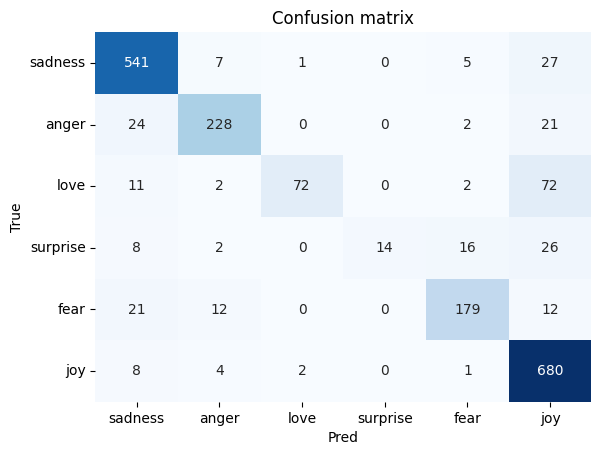

In [139]:
### Results

emotions = np.unique(y_test)

# Metrics
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print()
print("Results :")
for idx, em in enumerate([emotion_list[em] for em in emotions]) :
    print(f'{idx} : {em}')
print(metrics.classification_report(y_test, predicted))

# Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=[emotion_list[em] for em in emotions], 
       yticklabels=[emotion_list[em] for em in emotions], title="Confusion matrix")
plt.yticks(rotation=0)
print()


#### Lm based approach : Bert

In [33]:
# imports
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer
import random
import tabulate
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from tqdm import trange

In [9]:
# with lighter version distillbert
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [18]:
# load corpus and labels
text, y = list(df_train['text']), list(df_train['emotion']) # taking raw text
labels = [emotion_list.index(em) for em in y]
df_val = df_test = pd.read_csv("data/val.txt", names=["text", "emotion"], sep=";") 

# adding val set (to get the maxlen) --> resplitting it later
text.extend(list(df_test['text']))
labels.extend([emotion_list.index(em) for em in list(df_val['emotion'])])

# determining maxlen needed
maxlen = 0
for sent in list(text):
    if len(sent) > maxlen :
        maxlen = len(sent.split(' '))
print(f'max len : {maxlen}')


max len : 18


Preprocessing

In [19]:
## BERT preprocessing requirements
# Adding CLS and END tokens, normalize sentence length, create attention mask

def bert_preprocess(text, tokenizer):
    """
    Apply preprocessing needed for bert. see comment above
    """
    return tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = 20,
        pad_to_max_length = True,
        return_attention_mask = True,
        truncation = True,
        return_tensors = 'pt',
    )

token_id = []
attention_masks = []

for sentence in text:
    encoding_dict = bert_preprocess(sentence, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])

token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

print(f'Sentence tokenized example :\n{text[0]} :\n{token_id[0]}')

Sentence tokenized example :
i didnt feel humiliated :
tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [44]:
val_ratio = .2
batch_size = 16

# resplitting val set
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# train set 80%
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

# validation set 20%
val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])



# dataloaders
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )


Fine-tuning :
- hyperparameters based on https://arxiv.org/pdf/1810.04805.pdf

In [39]:
# Metrics :
def get_metrics(preds, labels):
    '''
    returns metrics
    '''
    preds = np.argmax(preds, axis = 1).flatten()
    labels = labels.flatten()
    tp = sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])
    tn = sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])
    fp = sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])
    fn = sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])
    b_accuracy = (tp + tn) / len(labels)
    b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
    
    return b_accuracy, b_recall

In [37]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 6,
    output_attentions = False,
    output_hidden_states = False,
)

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# model.cuda() # comment if no gpu available

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 2

# training template
for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_recall = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_recall= b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        
        # Update recall only when (tp + fn) != 0
        if b_recall != 'nan': 
            val_recall.append(b_recall)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')



Epoch:   0%|          | 0/2 [03:51<?, ?it/s]

KeyboardInterrupt



In [ ]:
# --> should retrain the model on train + val data

Testing results

In [ ]:
# load test data

test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )
